# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
import random
import matplotlib.pyplot as plt

%matplotlib inline

from ddpg_agent import Agent

In [2]:
# check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [3]:
# on Windows (GPU enabled)
# env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print('Using Brain:', brain_name)

Using Brain: TennisBrain


### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [6]:
# for i_ep in range(1, 6):                                      # play game for 5 episodes
#     env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#     states = env_info.vector_observations                  # get the current state (for each agent)
#     scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#     while True:
#         actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#         actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#         env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#         next_states = env_info.vector_observations         # get next state (for each agent)
#         rewards = env_info.rewards                         # get reward (for each agent)
#         dones = env_info.local_done                        # see if episode finished
#         scores += env_info.rewards                         # update the score (for each agent)
#         states = next_states                               # roll over states to next time step
#         if np.any(dones):                                  # exit loop if episode finished
#             break
#     print('Score (max over agents) from episode {}: {}'.format(i_ep, np.max(scores)))

When finished, you can close the environment.

In [7]:
# env.close()

### 4. Train DDPG Agent (Multi)

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [8]:
# create agent
agent = Agent(state_size, action_size, 8)

scores_deque = deque(maxlen=100)
score_hist = []

Using device:  cuda:0


In [9]:
# train agent
N_EPS = 10000
print_every  = 100

    
for i_episode in range(1, N_EPS+1):
    env_info = env.reset(train_mode=True)[brain_name]     # turn train mode on for env
    states = env_info.vector_observations                 # get initial states
    agent.reset()                                         # reset agent
    scores = np.zeros(num_agents)                         # initialize the score (for each agent)

    while True:
        actions = [agent.act(states[0])]                # get first agents actions
        for i in range(1,num_agents):
            actions.append(agent.act(states[i]))        # get all other agents actions

        env_info = env.step(actions)[brain_name]        # send the actions to the environment
        next_states = env_info.vector_observations      # get the next state
        dones = env_info.local_done                     # see if episode has finished
        rewards = env_info.rewards                      # get reward (for each agent)
        scores += env_info.rewards                      # get total score for this episode

        
        # update using all agents
        for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            agent.step(state, action, reward, next_state, done)

        states = next_states

        if np.any(dones):
            break

    scores_deque.append(np.max(scores))
    score_hist.append(np.max(scores))
    print('\rEpisode {}\tAverage Score of Episode: {:.2f}\tAverage Score Last {}: {:.2f}'.format(i_episode, np.mean(scores), print_every, np.mean(scores_deque)), end="")
    if np.mean(scores_deque) > 0.5:
        torch.save(agent.actor_local.state_dict(), 'agent_checkpoints/checkpoint_actor_{:.2f}.pth'.format(np.mean(scores_deque) ))
        torch.save(agent.critic_local.state_dict(), 'agent_checkpoints/checkpoint_critic_{:.2f}.pth'.format(np.mean(scores_deque) ))
    if i_episode % print_every == 0:
        print('\rEpisode {}\tAverage Score Last {}: {:.5f}'.format(i_episode, print_every, np.mean(scores_deque)))



Episode 100	Average Score Last 100: 0.00.00	Average Score Last 100: 0.00
Episode 200	Average Score Last 100: 0.02.00	Average Score Last 100: 0.02
Episode 300	Average Score Last 100: 0.0805	Average Score Last 100: 0.085
Episode 400	Average Score Last 100: 0.0305	Average Score Last 100: 0.033
Episode 500	Average Score Last 100: 0.1110	Average Score Last 100: 0.11
Episode 600	Average Score Last 100: 0.1410	Average Score Last 100: 0.14
Episode 700	Average Score Last 100: 0.1410	Average Score Last 100: 0.145
Episode 800	Average Score Last 100: 0.1110	Average Score Last 100: 0.112
Episode 900	Average Score Last 100: 0.1410	Average Score Last 100: 0.144
Episode 1000	Average Score Last 100: 0.1305	Average Score Last 100: 0.13
Episode 1100	Average Score Last 100: 0.1405	Average Score Last 100: 0.14
Episode 1200	Average Score Last 100: 0.1405	Average Score Last 100: 0.144
Episode 1300	Average Score Last 100: 0.1710	Average Score Last 100: 0.17
Episode 1400	Average Score Last 100: 0.1610	Average 

C:\Users\heyke\Miniconda3\envs\drlnd\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


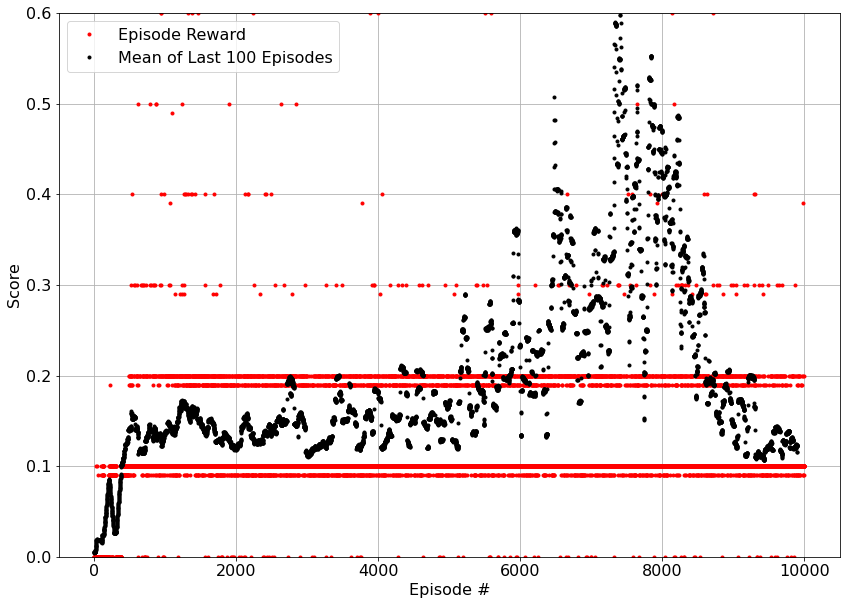

In [10]:
# print rewards history
plt.rcParams['font.size'] = '16'
fig = plt.figure(figsize=[14,10])
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(score_hist)+1), score_hist, 'r.', label='Episode Reward')
for i in np.arange(100, len(score_hist)):
    if i == 100:
        label = "Mean of Last 100 Episodes"
    else:
        label=None
    plt.plot(i-99, np.mean(score_hist[i-100:i]),'k.', label=label)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.grid()
plt.ylim([0, 0.6])
plt.legend()
plt.show()

### 5. Test the Agent

Test agent in the environment.

In [ ]:
# load the saved states if testing agent

# actor_state = torch.load('agent_checkpoints/checkpoint_actor.pth')
# critic_state = torch.load('agent_checkpoints/checkpoint_critic.pth')

# agent_to_test = Agent(state_size, action_size, 8, actor_state=actor_state, critic_state=critic_state)


In [ ]:

# num_eps = 6

# for i_ep in range(1, num_eps+1):                           # play game for n_eps episodes
#     env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#     states = env_info.vector_observations                  # get the current state (for each agent)
#     scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#     while True:
#         # test agent
#         actions = [agent.act(states[0])]                # get first agents actions
#         for i in range(1,num_agents):
#             actions.append(agent.act(states[i]))        # get all other agents actions

#         env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#         next_states = env_info.vector_observations         # get next state (for each agent)
#         rewards = env_info.rewards                         # get reward (for each agent)
#         dones = env_info.local_done                        # see if episode finished
#         scores += env_info.rewards                         # update the score (for each agent)
#         states = next_states                               # roll over states to next time step
#         if np.any(dones):                                  # exit loop if episode finished
#             break
#     print('Score (max over agents) from episode {}: {}'.format(i_ep, np.max(scores)))